In [47]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import pickle
import time
import pandas as pd

In [48]:
rng = np.random.default_rng()

In [49]:
class RewardGraphic():
    def __init__(self, window_size=1000):
        self.window_size = window_size

    def Graphic_reward_per_episode(self, rewards_per_episode, episodes, epsilons):
        plt.figure(figsize=(10, 6))  # Tamaño de la figura
        
        for i, epsilon in enumerate(epsilons):
            sum_rewards = np.zeros(episodes)
            for t in range(episodes):
                sum_rewards[t] = np.sum(rewards_per_episode[epsilon][max(0, t-self.window_size):(t+1)])

            print(f"Final average reward for epsilon={epsilon}:", np.mean(sum_rewards[-1000:]))
            plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')

        plt.xlabel('Episodes')
        plt.ylabel('Suma de recompensas')
        plt.title('Suma de recompensas a lo largo del tiempo')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'CliffWalking_combined.png')
        plt.show()
        
    def Graphic_reward_per_epsilon(self, reward_per_epsilon, epsilons):
        plt.figure(figsize=(8, 5))
        for epsilon in epsilons:
            plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Episodios')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')
        plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:27: SyntaxWarning: invalid escape sequence '\e'
<>:32: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_11496\1449826397.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(sum_rewards, label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_11496\1449826397.py:27: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(reward_per_epsilon[epsilon], label=f'$\epsilon$ = {epsilon}')
C:\Users\ANIMETX\AppData\Local\Temp\ipykernel_11496\1449826397.py:32: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Recompensa media por episodio para diferentes valores de $\epsilon$')


In [50]:
class Game():
    def __init__(self, Agent, explore=True):
        self.agent = Agent
        self.explore = explore
        self.url_pickle = f"CliffWalking{self.agent.epsilon}.pkl"
        if self.url_pickle is not None:
            self.is_explore()

    def is_explore(self):
        if self.explore:
            self.agent.q = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
            self.agent.actions = np.zeros(self.agent.env.action_space.n)
        else:
            with open(self.url_pickle, 'rb') as f:
                self.agent.q = pickle.load(f)
                self.agent.actions = np.zeros(self.agent.env.action_space.n)
    
    def save_Pickle(self):
        if self.explore:
            with open(self.url_pickle, "wb") as f:
                pickle.dump(self.agent.q, f)
    
    def run(self, episodes=100):
        RENDER_AT_EPISODE = 1
        rewards_per_episode = np.zeros(episodes)
        reward_graphic = RewardGraphic()
        
        for episode in range(episodes):
            state = self.agent.reset()
            self.agent.episode_reward = 0
            
            if self.explore and self.agent.epsilon == 0:
                # Inicializar Q con valores altos
                self.agent.q = np.zeros((self.agent.env.observation_space.n, self.agent.env.action_space.n))
            
            while True:
                action = self.agent.choose_action(state, self.explore)
                new_state, reward, terminated, truncated, _ = self.agent.env.step(action)
                
                done = terminated or truncated 
                if self.explore:
                    self.agent.learn(state, action, reward, new_state, done)
                
                self.agent.actions[action] += 1
                state = new_state
                self.agent.episode_reward += reward
                
                if done:
                    break
            
            if episode % RENDER_AT_EPISODE == 0:
                clear_output(wait=True)
                self.agent.env.render()
            
            # self.agent.epsilon = max(self.agent.epsilon - self.agent.epsilon_decay_rate, 0.01)
            rewards_per_episode[episode] = self.agent.episode_reward
            print(f"Episode {episode}/{episodes}, Epsilon: {self.agent.epsilon:.4f}, Reward: {self.agent.episode_reward:.4f}")
        self.save_Pickle()
        self.agent.env.close()
        return rewards_per_episode

In [51]:
class Agent():
    def __init__(self, epsilon=1, epsilon_decay_rate=0.0001, alpha=0.0009, gamma=0.99, render=False):
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.alpha = alpha
        self.gamma = gamma
        self.render = render
        self.episode_reward = 0
        self.env = gym.make('CliffWalking-v0', render_mode="human" if render else None)
        self.q = None
        self.actions = None
    
    def reset(self):
        return self.env.reset()[0] 
    
    def is_explore(self, explore, state):
        if explore:
            return self.env.action_space.sample()
        else:
            max_q = np.max(self.q[state, :])
            actions = np.where(self.q[state, :] == max_q)[0]
            print(f"Estado: {state}, Accion: {np.random.choice(actions)}")
            action = np.random.choice(actions)
            return action
    
    def choose_action(self, state, explore):
        if explore and np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self.is_explore(explore, state)

    def learn(self, state, action, reward, next_state, done):
        
        best_next_action = np.argmax(self.q[next_state, :])
        td_target = reward + self.gamma * self.q[next_state, best_next_action] * (not done)
        #donde td_target es valor objetivo de la ecuacion de Bellman
        self.q[state, action] += self.alpha * (td_target - self.q[state, action])

In [52]:
epsilons = [0, 1]
reward_per_epsilon = {}
reward_per_episode = {}
games = {}
graphic = RewardGraphic()

for epsilon in epsilons:
    print(f"Training Agent with epsilon: {epsilon}")
    agent = Agent(epsilon=epsilon, render=False)
    game = Game(agent, explore=True)
    game.url_pickle = f"CliffWalking{epsilon}.pkl"
    games[epsilon] = game

for epsilon, game in games.items():
    episodes = 500
    reward_per_episode[epsilon] = game.run(episodes)
    reward_per_epsilon[epsilon] =  reward_per_episode[epsilon]/ episodes

Episode 499/500, Epsilon: 1.0000, Reward: -65072.0000


Final average reward for epsilon=0: -17194247.46
Final average reward for epsilon=1: -15795424.554


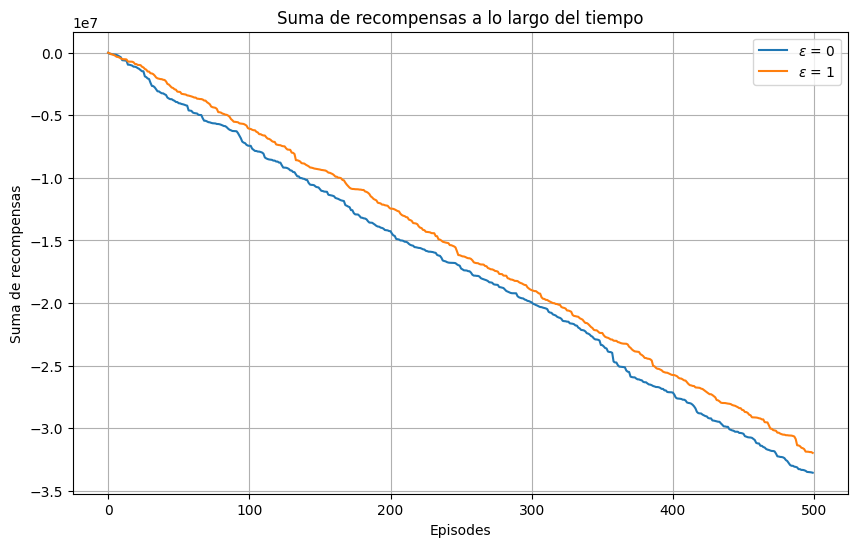

In [53]:
graphic.Graphic_reward_per_episode(reward_per_episode, episodes, epsilons)

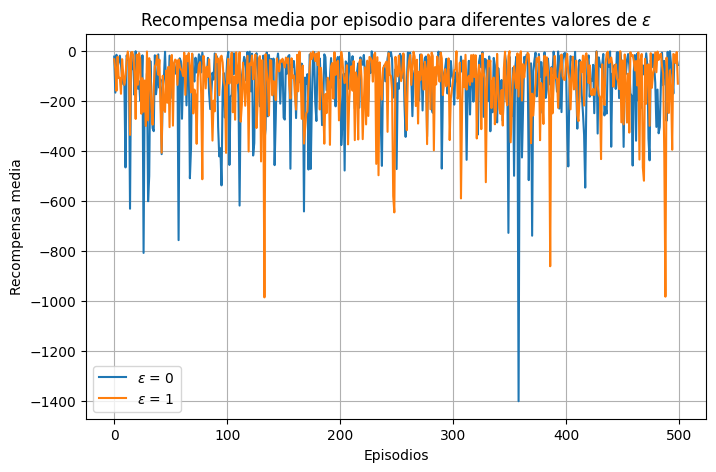

In [54]:
graphic.Graphic_reward_per_epsilon(reward_per_epsilon, epsilons)

In [ ]:
agent = Agent(epsilon=0, render=True)
game = Game(agent, explore=False)
game.run(2)

0: Move up

1: Move right

2: Move down

3: Move left

In [57]:
q_df = pd.DataFrame(games[0].agent.q)
print("Q-table as DataFrame:")
q_df

Q-table as DataFrame:


,0,1,2,3
0,-0.052512,-0.042007,-0.040539,-0.034194
1,-0.029671,-0.032144,-0.035004,-0.030606
2,-0.023322,-0.024992,-0.019797,-0.021618
3,-0.009000,-0.018779,-0.013463,-0.018008
4,-0.014335,-0.006292,-0.016996,-0.014344
5,-0.008973,-0.006293,-0.004493,-0.008981
6,-0.008972,-0.003597,-0.003598,-0.005393
7,-0.000900,-0.002698,-0.003598,-0.000901
8,-0.001799,-0.002698,-0.002699,-0.000901
9,-0.001800,-0.000900,-0.004494,-0.002698
